In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dimention reduction

## Load data

In [2]:
class_name = 'Cultivars'

feature_cols = [
        'Alcohol',
        'Malic_acid',
        'Ash',
        'Alcalinity_of_ash',
        'Magnesium',
        'Total_phenols',
        'Flavanoids',
        'Nonflavanoid_phenols',
        'Proanthocyanins',
        'Color_intensity',
        'Hue',
        'OD280/OD315_of_diluted_wines',
        'Proline'
    ]

cols = feature_cols.copy()
cols.insert(0, class_name)

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', 
                 header=None, names=cols)

features = df.drop(class_name, axis=1)
target = df[class_name]

df.head()

,Cultivars,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## PCA

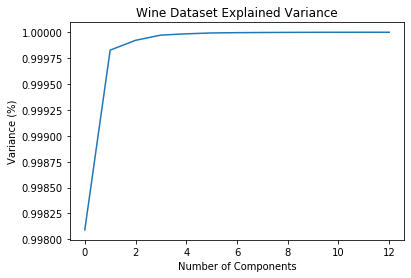

In [3]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA().fit(features)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Wine Dataset Explained Variance')
plt.show()

In [4]:
def zip_features_and_class(features_, class_):
    df_ = pd.DataFrame({'x': features_[:, 0], 'y': features_[:, 1]})
    result = pd.concat([df_, class_], axis=1, sort=False)
    return result

def plot_reduced_dataset(df_):
    groups = df_.groupby(class_name)

    # Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7)
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms='7', label=name)
    ax.legend()
    plt.show()

In [5]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
res_pca = zip_features_and_class(reduced_features, target)
res_pca

,x,y,Cultivars
0,318.562979,21.492131,1
1,303.097420,-5.364718,1
2,438.061133,-6.537309,1
3,733.240139,0.192729,1
4,-11.571428,18.489995,1
...,...,...,...
173,-6.980211,-4.541137,3
174,3.131605,2.335191,3
175,88.458074,18.776285,3
176,93.456242,18.670819,3


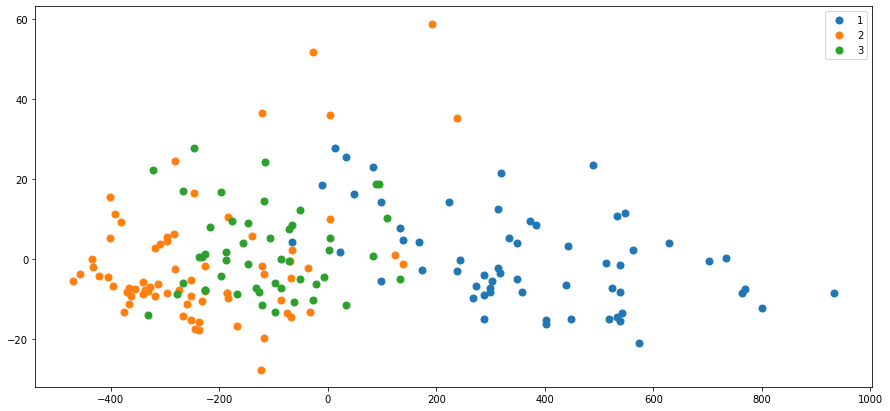

In [6]:
plot_reduced_dataset(res_pca)

## TSNE

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(features)
res_tsne = zip_features_and_class(reduced_features, target)
res_tsne

,x,y,Cultivars
0,11.694333,-0.501952,1
1,11.391916,0.256321,1
2,13.946042,-0.219492,1
3,16.801126,-0.594443,1
4,2.952987,0.500355,1
...,...,...,...
173,2.914620,0.072234,3
174,3.350892,0.096147,3
175,5.988004,0.189804,3
176,6.169344,0.317254,3


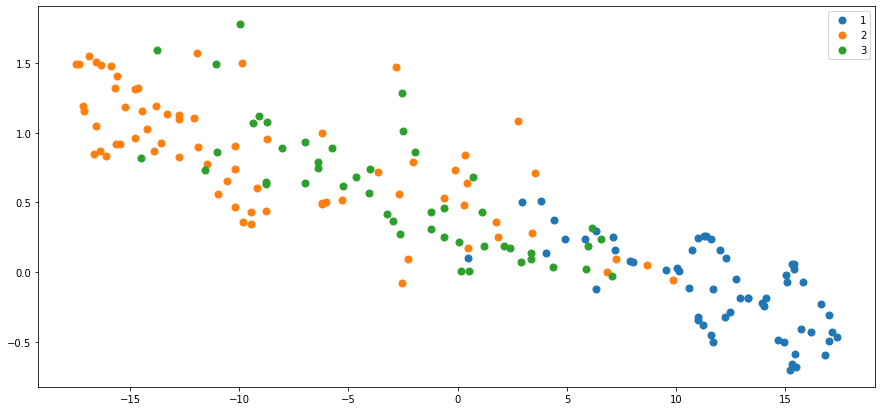

In [8]:
plot_reduced_dataset(res_tsne)